# Выполнил: Алексей Сек, БЭК182

In [1]:
# Импортируем библиотеки

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats.stats as stats
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import auc, roc_curve, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder

import pandas.core.algorithms as algos
from pandas import Series
import re
import traceback
import string

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Импортируем данные
accept = pd.read_csv('/Users/alexeysek/Desktop/SAS/HW3/12_accept.csv')
reject = pd.read_csv('/Users/alexeysek/Desktop/SAS/HW3/12_reject.csv')

### Выборка Accept + Reject - пукнты 2,3

In [3]:
acc_rej = pd.concat([accept, reject])
acc_rej

,target,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,income,DEPENDANT_NUMBER,IS_EMPL,COUNT_ACTIVE_CREDIT_NO_CC,CNT_MNTH_FROM_LAST_PMNT,age,experience,inquiry_14_day,inquiry_21_day,count_mnth_act_passport,UID
0,0.0,OTHER,elementary,NaN,140000.0,0.0,0,0.0,34.218548,38.497103,4.060109,NaN,NaN,10.056007,7
1,0.0,OTHER,elementary,NaN,50000.0,0.0,0,NaN,NaN,32.120548,4.743604,NaN,NaN,1.553425,18
2,0.0,OTHER,elementary,Corporate,183461.0,0.0,1,0.0,1.186985,44.063014,0.512194,1.0,1.0,2.649315,23
3,0.0,OTHER,elementary,Corporate,183461.0,0.0,1,0.0,1.186985,44.063014,0.512194,1.0,1.0,2.649315,24
4,0.0,OTHER,elementary,Corporate,102984.0,0.0,1,NaN,NaN,34.883928,6.119545,NaN,NaN,1.757901,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10688,NaN,2NDFL,advanced,NaN,24311.0,0.0,0,NaN,NaN,23.456284,1.188060,NaN,NaN,3.401639,140863
10689,NaN,OTHER,elementary,NaN,21400.0,0.0,0,0.0,1.271550,24.040984,0.994303,0.0,0.0,2.739509,140864
10690,NaN,OTHER,elementary,Corporate,22532.0,0.0,1,1.0,0.601299,24.442623,0.568531,1.0,1.0,4.377049,140869
10691,NaN,OTHER,elementary,NaN,21750.0,0.0,0,NaN,NaN,23.218579,0.742039,NaN,NaN,3.002313,140885


### Интервальные переменные

In [4]:
# Посмотрим, какие типы переменных в нашей выборке
acc_rej.dtypes

target                       float64
INCOME_TYPE                   object
EDUCATION_                    object
CUSTOMER_CATEGORY_            object
income                       float64
DEPENDANT_NUMBER             float64
IS_EMPL                        int64
COUNT_ACTIVE_CREDIT_NO_CC    float64
CNT_MNTH_FROM_LAST_PMNT      float64
age                          float64
experience                   float64
inquiry_14_day               float64
inquiry_21_day               float64
count_mnth_act_passport      float64
UID                            int64
dtype: object

In [5]:
# Вытащим отдельно категориальные переменные и отдельно интервальные
num = (acc_rej.dtypes != 'object').values
cat = (acc_rej.dtypes == 'object').values

In [6]:
# Посмотрим основные статистики по переменным
# Код для медианы: https://stackoverflow.com/questions/38545828/pandas-describe-by-additional-parameters
def describe(df, stats):
    d = df.describe()
    return d.append(df.reindex(d.columns, axis=1).agg(stats))

describe(acc_rej.loc[:,num],['median']).T

,count,mean,std,min,25%,50%,75%,max,median
target,32554.0,0.021411,0.144751,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000
income,42042.0,54828.445769,92965.348772,0.000000,25000.000000,37410.000000,60000.000000,1.145038e+07,37410.000000
DEPENDANT_NUMBER,43209.0,0.005948,0.093715,0.000000,0.000000,0.000000,0.000000,4.000000e+00,0.000000
IS_EMPL,43247.0,0.429995,0.495081,0.000000,0.000000,0.000000,1.000000,1.000000e+00,0.000000
COUNT_ACTIVE_CREDIT_NO_CC,30526.0,0.637522,0.806163,0.000000,0.000000,0.000000,1.000000,8.000000e+00,0.000000
CNT_MNTH_FROM_LAST_PMNT,27703.0,23.220069,155.782441,-31.072849,0.529032,0.923029,3.183300,1.364633e+03,0.923029
age,43247.0,33.409682,8.931385,0.002732,25.075982,31.163934,39.554035,5.893780e+01,31.163934
experience,43198.0,4.127523,4.884811,0.000000,0.958453,2.405479,5.386301,1.011924e+02,2.405479
inquiry_14_day,29517.0,0.354541,0.609662,0.000000,0.000000,0.000000,1.000000,6.000000e+00,0.000000
inquiry_21_day,29517.0,0.421350,0.687740,0.000000,0.000000,0.000000,1.000000,8.000000e+00,0.000000


In [7]:
# Эту функцию написал еще в HW1, использую ее тут тоже

# Посчитаем уникальные значения по каждому столбцу
# Количество уникальных значений как доля от общего числа значений !не учитывая пустые!
def unique_share(df):
    uniques_share = []
    uniques = []

    for col in df:
            uniques.append(len(df[col].unique()))
            uniques_share.append(len(df[col].unique()) / (df[col]).count())

    # Количество пустных(nan) и нулевых (zero) значений по столбцам как доля от общего числа
    # Также добавил абсолютные количества уникальных, нулевых и пустых значений
    null_nan_df = pd.DataFrame()
    null_nan_df['nan'] = (max(df.isnull().count()) - df.count()) 
    null_nan_df['zero'] = (df == 0).sum() 
    null_nan_df['unique'] = uniques
    null_nan_df['nan_share'] = (max(df.isnull().count()) - df.count()) / max(df.isnull().count())
    null_nan_df['zero_share'] = (df == 0).sum() / max(df.count())
    null_nan_df['unique_share'] = uniques_share
    return null_nan_df

In [8]:
# Выведем пропущенные значения (nan_share)
unique_share(acc_rej.loc[:,num])

,nan,zero,unique,nan_share,zero_share,unique_share
target,10693,31857,3,0.247254,0.736629,0.000092
income,1205,6,23714,0.027863,0.000139,0.564055
DEPENDANT_NUMBER,38,43006,6,0.000879,0.994427,0.000139
IS_EMPL,0,24651,2,0.000000,0.570005,0.000046
COUNT_ACTIVE_CREDIT_NO_CC,12721,15762,10,0.294148,0.364465,0.000328
CNT_MNTH_FROM_LAST_PMNT,15544,24,20555,0.359424,0.000555,0.741977
age,0,0,29954,0.000000,0.000000,0.692626
experience,49,1,26598,0.001133,0.000023,0.615723
inquiry_14_day,13730,20742,8,0.317479,0.479617,0.000271
inquiry_21_day,13730,19583,10,0.317479,0.452818,0.000339


Значения IV будут посчитаны ниже

### Категориальные переменные

In [9]:
# Функция для подсчета частоты каждого из значений по каждой категориальной переменной
def count_cat_unique(df):
    cols = df.columns.values
    
    for col in cols:
        print(col)
        print(df.loc[:,col].value_counts())

In [10]:
# Мода = самое частое значение
# Вручную перенесу в excel
count_cat_unique(acc_rej.loc[:,cat])

INCOME_TYPE
OTHER    28484
2NDFL    14763
Name: INCOME_TYPE, dtype: int64
EDUCATION_
elementary    28101
advanced      10916
high           2386
beginner       1844
Name: EDUCATION_, dtype: int64
CUSTOMER_CATEGORY_
Corporate    18403
VIP            439
Name: CUSTOMER_CATEGORY_, dtype: int64


In [11]:
# Посчитаем пропущенные значения
unique_share(acc_rej.loc[:,cat])

,nan,zero,unique,nan_share,zero_share,unique_share
INCOME_TYPE,0,0,2,0.000000,0.0,0.000046
EDUCATION_,0,0,4,0.000000,0.0,0.000092
CUSTOMER_CATEGORY_,24405,0,3,0.564317,0.0,0.000159


Значения IV будут посчитаны ниже

### Выбросы и аномальные значения

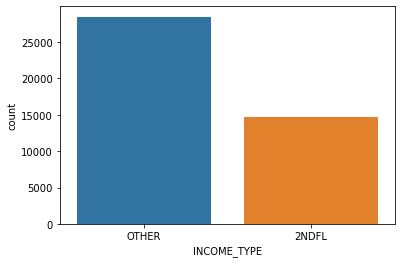

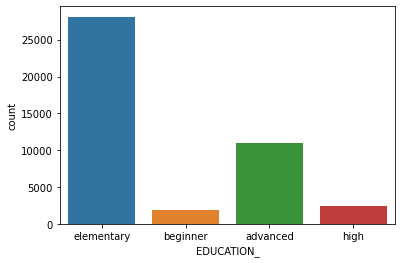

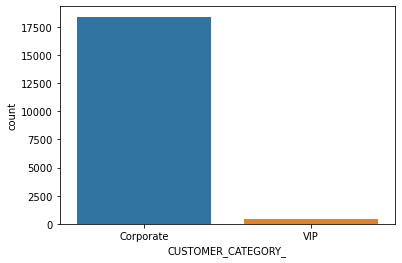

In [12]:
# Посмотрим графики по категориальным переменным
cat_cols = acc_rej.loc[:,cat].columns.values

for col in cat_cols:
    sns.countplot(acc_rej[col])
    plt.show()

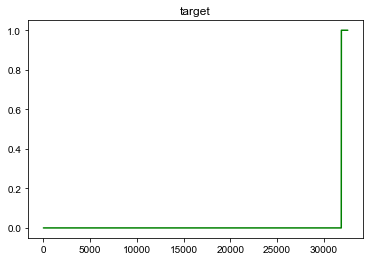

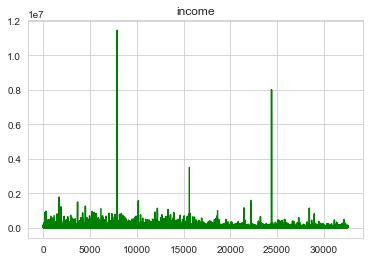

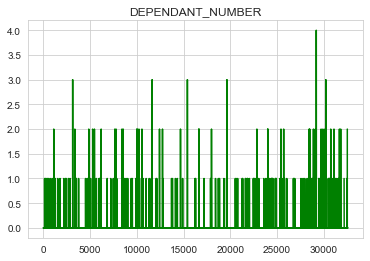

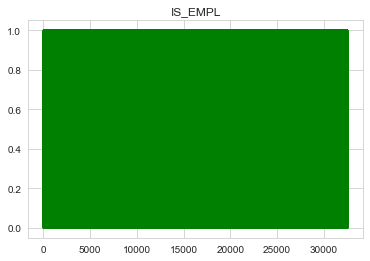

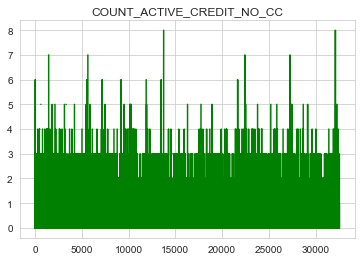

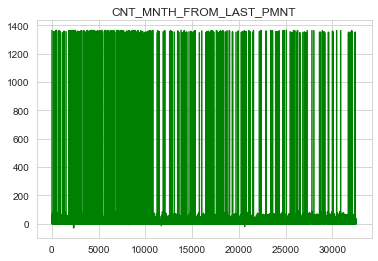

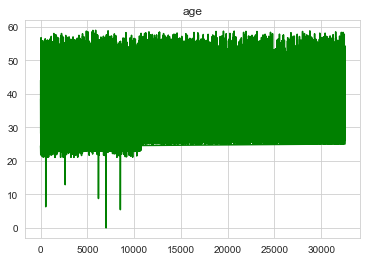

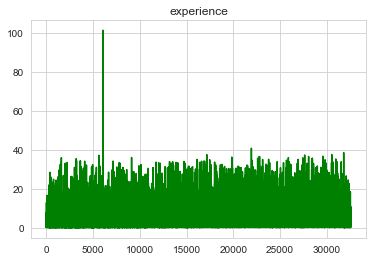

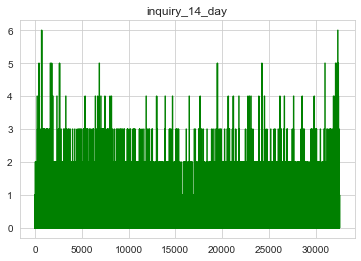

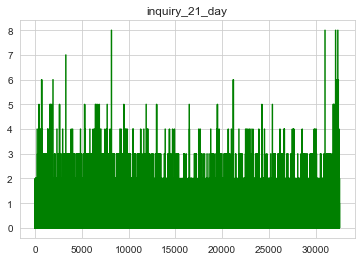

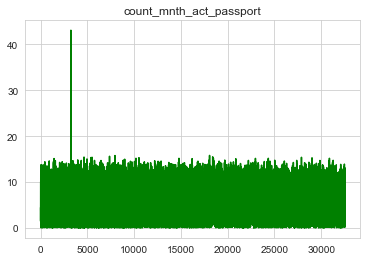

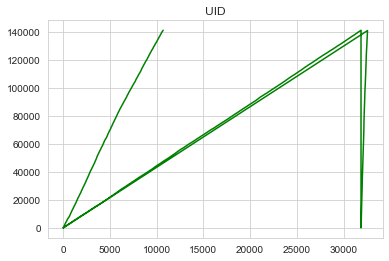

In [13]:
# Посмотрим графики по интервальным переменным (по идее можно удалить таргет отсюда, но я не стал)
num_cols = acc_rej.loc[:,num].columns.values

for col in num_cols:
    plt.title(col)
    sns.set_style("whitegrid")
    plt.plot(acc_rej[col], 'g')
    plt.show()

**Выводы из анализа выбросов:**
- В income три выброса - я дропну все выше, чем 0.2 * 10^7
- CNT_MNTH_FROM_LAST_PMNT принимает отрицательные значения, такого быть не может, поэтому дропнем наблюдения с отрицательными значениями
- В столбце experience есть один выброс - 100 лет, это выглядит странным) опыт 100 лет точно стоит дропнуть
- В категориальных признаков нет анормальных значений, которые стоит дропнуть
- Среди числовых переменных DEPENDANT_NUMBER, COUNT_ACTIVE_CREDIT_NO_CC, age, inquiry_14_day, inquiry_21_day, count_mnth_act_passport, UID не требуют корректировок
- IS_EMPL принимает значения только 0 и 1, здесь нет аномальных значений

In [14]:
# Сколько было строк изначально
acc_rej.shape

(43247, 15)

In [15]:
# Удалим выбросы
acc_rej.drop(index = acc_rej[acc_rej['CNT_MNTH_FROM_LAST_PMNT'] < 0].index, inplace=True)
acc_rej.drop(index = acc_rej[acc_rej['experience'] >80].index, inplace=True)
acc_rej.drop(index = acc_rej[acc_rej['income'] > 0.2 * (10**7)].index, inplace=True)
acc_rej

# Строк стало меньше

,target,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,income,DEPENDANT_NUMBER,IS_EMPL,COUNT_ACTIVE_CREDIT_NO_CC,CNT_MNTH_FROM_LAST_PMNT,age,experience,inquiry_14_day,inquiry_21_day,count_mnth_act_passport,UID
0,0.0,OTHER,elementary,NaN,140000.0,0.0,0,0.0,34.218548,38.497103,4.060109,NaN,NaN,10.056007,7
1,0.0,OTHER,elementary,NaN,50000.0,0.0,0,NaN,NaN,32.120548,4.743604,NaN,NaN,1.553425,18
2,0.0,OTHER,elementary,Corporate,183461.0,0.0,1,0.0,1.186985,44.063014,0.512194,1.0,1.0,2.649315,23
3,0.0,OTHER,elementary,Corporate,183461.0,0.0,1,0.0,1.186985,44.063014,0.512194,1.0,1.0,2.649315,24
4,0.0,OTHER,elementary,Corporate,102984.0,0.0,1,NaN,NaN,34.883928,6.119545,NaN,NaN,1.757901,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10688,NaN,2NDFL,advanced,NaN,24311.0,0.0,0,NaN,NaN,23.456284,1.188060,NaN,NaN,3.401639,140863
10689,NaN,OTHER,elementary,NaN,21400.0,0.0,0,0.0,1.271550,24.040984,0.994303,0.0,0.0,2.739509,140864
10690,NaN,OTHER,elementary,Corporate,22532.0,0.0,1,1.0,0.601299,24.442623,0.568531,1.0,1.0,4.377049,140869
10691,NaN,OTHER,elementary,NaN,21750.0,0.0,0,NaN,NaN,23.218579,0.742039,NaN,NaN,3.002313,140885


## Выборка accept

In [16]:
# Доля 1 в выборке accept
print('Доля 1 в accept', "{:.2%}".format(sum(accept.target == 1) / len(accept.target)))

Доля 1 в accept 2.14%


### Интервальные переменные

In [17]:
# Посмотрим, какие типы переменных в нашей выборке
accept.dtypes

target                         int64
INCOME_TYPE                   object
EDUCATION_                    object
CUSTOMER_CATEGORY_            object
income                       float64
DEPENDANT_NUMBER             float64
IS_EMPL                        int64
COUNT_ACTIVE_CREDIT_NO_CC    float64
CNT_MNTH_FROM_LAST_PMNT      float64
age                          float64
experience                   float64
inquiry_14_day               float64
inquiry_21_day               float64
count_mnth_act_passport      float64
UID                            int64
dtype: object

In [18]:
# Вытащим отдельно категориальные переменные и отдельно интервальные
num = (accept.dtypes != 'object').values
cat = (accept.dtypes == 'object').values

In [19]:
# Посмотрим основные статистики по переменным
# Код для медианы: https://stackoverflow.com/questions/38545828/pandas-describe-by-additional-parameters
def describe(df, stats):
    d = df.describe()
    return d.append(df.reindex(d.columns, axis=1).agg(stats))

describe(accept.loc[:,num],['median']).T

,count,mean,std,min,25%,50%,75%,max,median
target,32554.0,0.021411,0.144751,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000
income,31895.0,61565.711177,105131.379580,0.000000,26935.000000,41412.000000,70000.000000,1.145038e+07,41412.000000
DEPENDANT_NUMBER,32521.0,0.007318,0.104666,0.000000,0.000000,0.000000,0.000000,4.000000e+00,0.000000
IS_EMPL,32554.0,0.392794,0.488379,0.000000,0.000000,0.000000,1.000000,1.000000e+00,0.000000
COUNT_ACTIVE_CREDIT_NO_CC,24241.0,0.662555,0.822730,0.000000,0.000000,0.000000,1.000000,8.000000e+00,0.000000
CNT_MNTH_FROM_LAST_PMNT,22477.0,18.742477,132.783699,-21.953293,0.530556,0.926882,3.660932,1.364348e+03,0.926882
age,32554.0,36.488288,8.213396,25.000187,29.568469,34.783229,42.336986,5.893780e+01,34.783229
experience,32513.0,4.938418,5.329746,0.000000,1.241126,3.286885,6.534247,1.011924e+02,3.286885
inquiry_14_day,23428.0,0.358161,0.607001,0.000000,0.000000,0.000000,1.000000,6.000000e+00,0.000000
inquiry_21_day,23428.0,0.423254,0.682330,0.000000,0.000000,0.000000,1.000000,8.000000e+00,0.000000


In [20]:
# Эту функцию написал еще в HW1, использую ее тут тоже

# Посчитаем уникальные значения по каждому столбцу
# Количество уникальных значений как доля от общего числа значений !не учитывая пустые!
def unique_share(df):
    uniques_share = []
    uniques = []

    for col in df:
            uniques.append(len(df[col].unique()))
            uniques_share.append(len(df[col].unique()) / (df[col]).count())

    # Количество пустных(nan) и нулевых (zero) значений по столбцам как доля от общего числа
    # Также добавил абсолютные количества уникальных, нулевых и пустых значений
    null_nan_df = pd.DataFrame()
    null_nan_df['nan'] = (max(df.isnull().count()) - df.count()) 
    null_nan_df['zero'] = (df == 0).sum() 
    null_nan_df['unique'] = uniques
    null_nan_df['nan_share'] = (max(df.isnull().count()) - df.count()) / max(df.isnull().count())
    null_nan_df['zero_share'] = (df == 0).sum() / max(df.count())
    null_nan_df['unique_share'] = uniques_share
    return null_nan_df

In [21]:
# Выведем пропущенные значения (nan_share)
unique_share(accept.loc[:,num])

,nan,zero,unique,nan_share,zero_share,unique_share
target,0,31857,2,0.000000,0.978589,0.000061
income,659,2,18425,0.020243,0.000061,0.577677
DEPENDANT_NUMBER,33,32335,6,0.001014,0.993273,0.000184
IS_EMPL,0,19767,2,0.000000,0.607206,0.000061
COUNT_ACTIVE_CREDIT_NO_CC,8313,12210,10,0.255360,0.375069,0.000413
CNT_MNTH_FROM_LAST_PMNT,10077,21,17334,0.309547,0.000645,0.771188
age,0,0,24315,0.000000,0.000000,0.746913
experience,41,1,21325,0.001259,0.000031,0.655891
inquiry_14_day,9126,16342,8,0.280334,0.501997,0.000341
inquiry_21_day,9126,15452,10,0.280334,0.474657,0.000427


Значения IV будут посчитаны ниже

### Категориальные переменные

In [22]:
# Функция для подсчета частоты каждого из значений по каждой категориальной переменной
def count_cat_unique(df):
    cols = df.columns.values
    
    for col in cols:
        print(col)
        print(df.loc[:,col].value_counts())

In [23]:
# Мода = самое частое значение
# Вручную перенесу в excel
count_cat_unique(accept.loc[:,cat])

INCOME_TYPE
OTHER    21800
2NDFL    10754
Name: INCOME_TYPE, dtype: int64
EDUCATION_
elementary    21323
advanced       8459
beginner       1561
high           1211
Name: EDUCATION_, dtype: int64
CUSTOMER_CATEGORY_
Corporate    12763
VIP            428
Name: CUSTOMER_CATEGORY_, dtype: int64


In [24]:
# Посчитаем пропущенные значения
unique_share(accept.loc[:,cat])

,nan,zero,unique,nan_share,zero_share,unique_share
INCOME_TYPE,0,0,2,0.000000,0.0,0.000061
EDUCATION_,0,0,4,0.000000,0.0,0.000123
CUSTOMER_CATEGORY_,19363,0,3,0.594796,0.0,0.000227


Значения IV будут посчитаны ниже

### Выбросы и аномальные значения

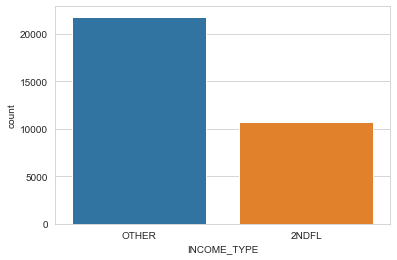

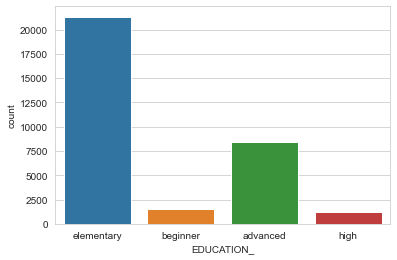

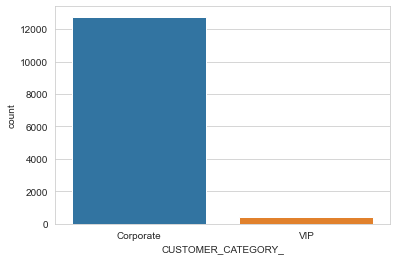

In [25]:
# Посмотрим графики по категориальным переменным
cat_cols = accept.loc[:,cat].columns.values

for col in cat_cols:
    sns.countplot(accept[col])
    plt.show()

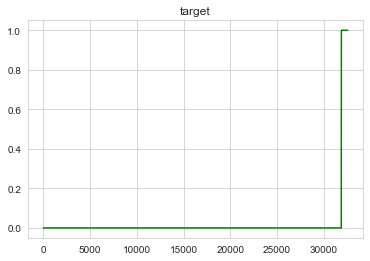

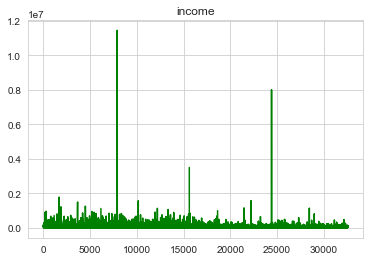

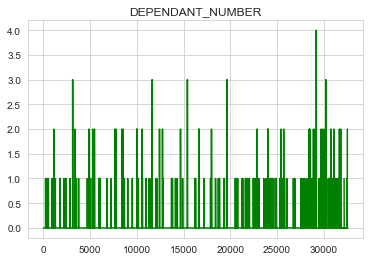

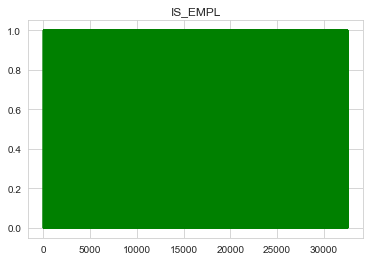

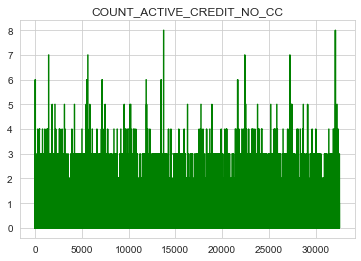

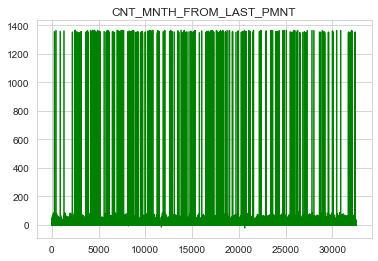

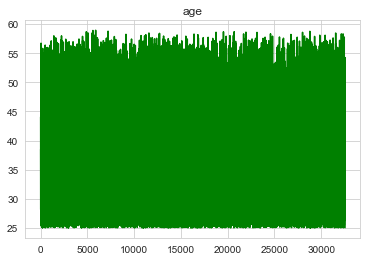

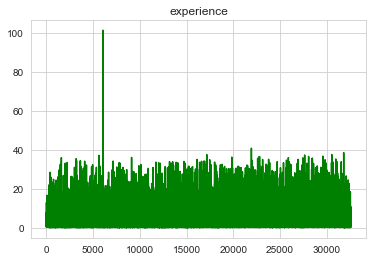

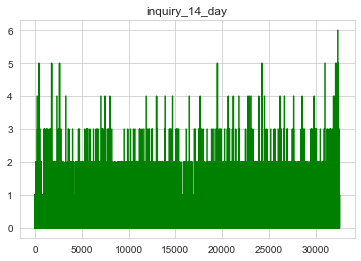

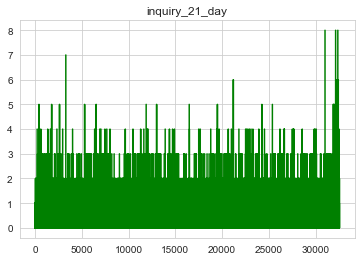

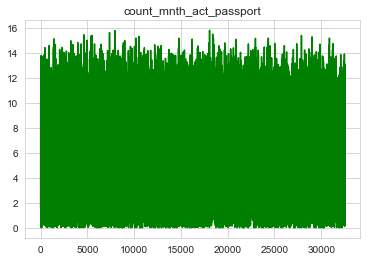

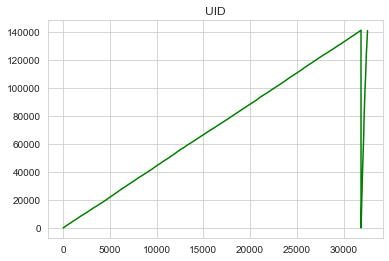

In [26]:
# Посмотрим графики по интервальным переменным (по идее можно удалить таргет отсюда, но я не стал)
num_cols = accept.loc[:,num].columns.values

for col in num_cols:
    plt.title(col)
    sns.set_style("whitegrid")
    plt.plot(accept[col], 'g')
    plt.show()

**Выводы из анализа выбросов:**
- В income три выброса - я дропну все выше, чем 0.2 * 10^7
- CNT_MNTH_FROM_LAST_PMNT принимает отрицательные значения, такого быть не может, поэтому дропнем наблюдения с отрицательными значениями
- В столбце experience есть один выброс - 100 лет, это выглядит странным) опыт 100 лет точно стоит дропнуть
- В категориальных признаков нет анормальных значений, которые стоит дропнуть
- Среди числовых переменных DEPENDANT_NUMBER, COUNT_ACTIVE_CREDIT_NO_CC, age, inquiry_14_day, inquiry_21_day, count_mnth_act_passport, UID не требуют корректировок
- IS_EMPL принимает значения только 0 и 1, здесь нет аномальных значений

In [27]:
# Сколько было строк изначально
accept.shape

(32554, 15)

In [28]:
# Удалим выбросы
accept.drop(index = accept[accept['CNT_MNTH_FROM_LAST_PMNT'] < 0].index, inplace=True)
accept.drop(index = accept[accept['experience'] >80].index, inplace=True)
accept.drop(index = accept[accept['income'] > 0.2 * (10**7)].index, inplace=True)
accept

# Строк стало меньше

,target,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,income,DEPENDANT_NUMBER,IS_EMPL,COUNT_ACTIVE_CREDIT_NO_CC,CNT_MNTH_FROM_LAST_PMNT,age,experience,inquiry_14_day,inquiry_21_day,count_mnth_act_passport,UID
0,0,OTHER,elementary,NaN,140000.0,0.0,0,0.0,34.218548,38.497103,4.060109,NaN,NaN,10.056007,7
1,0,OTHER,elementary,NaN,50000.0,0.0,0,NaN,NaN,32.120548,4.743604,NaN,NaN,1.553425,18
2,0,OTHER,elementary,Corporate,183461.0,0.0,1,0.0,1.186985,44.063014,0.512194,1.0,1.0,2.649315,23
3,0,OTHER,elementary,Corporate,183461.0,0.0,1,0.0,1.186985,44.063014,0.512194,1.0,1.0,2.649315,24
4,0,OTHER,elementary,Corporate,102984.0,0.0,1,NaN,NaN,34.883928,6.119545,NaN,NaN,1.757901,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32549,1,OTHER,elementary,NaN,78000.0,0.0,0,NaN,NaN,54.251037,0.371585,NaN,NaN,6.749667,140104
32550,1,2NDFL,elementary,NaN,59032.0,0.0,0,3.0,0.339740,27.344262,3.986339,0.0,0.0,7.081323,140230
32551,1,2NDFL,elementary,NaN,49296.0,0.0,0,0.0,NaN,25.795831,4.139344,1.0,2.0,5.760214,140245
32552,1,OTHER,advanced,NaN,35000.0,0.0,0,0.0,35.698701,43.907104,10.975178,0.0,0.0,9.906685,140398


### Логистическая регрессия только на одобренных заявках с преобразованными переменными WoE

In [29]:
# Заполним пропуски
accept.loc[:, num] = accept.loc[:, num].fillna(accept.loc[:, num].mean())
accept.loc[:, cat] = accept.loc[:, cat].fillna('Unknown_cat')

In [30]:
cat_cols

array(['INCOME_TYPE', 'EDUCATION_', 'CUSTOMER_CATEGORY_'], dtype=object)

In [31]:
accept.columns.values

array(['target', 'INCOME_TYPE', 'EDUCATION_', 'CUSTOMER_CATEGORY_',
       'income', 'DEPENDANT_NUMBER', 'IS_EMPL',
       'COUNT_ACTIVE_CREDIT_NO_CC', 'CNT_MNTH_FROM_LAST_PMNT', 'age',
       'experience', 'inquiry_14_day', 'inquiry_21_day',
       'count_mnth_act_passport', 'UID'], dtype=object)

In [32]:
# Необходимо преобразование категориальных переменных

# Считаю, что стоит закодировать education и customer category через label encoder, а income type через one hot encoder
# Идея такая, что порядок для первых двух важен, а для последней нет
# Но так как в income type всего два значения - можно его тоже закодировать через le, идейно значимой разницы не будет 

le = LabelEncoder()

accept['INCOME_TYPE'] = le.fit_transform(accept['INCOME_TYPE'])
accept['EDUCATION_'] = le.fit_transform(accept['EDUCATION_'])
accept['CUSTOMER_CATEGORY_'] = le.fit_transform(accept['CUSTOMER_CATEGORY_'])

accept.head()

,target,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,income,DEPENDANT_NUMBER,IS_EMPL,COUNT_ACTIVE_CREDIT_NO_CC,CNT_MNTH_FROM_LAST_PMNT,age,experience,inquiry_14_day,inquiry_21_day,count_mnth_act_passport,UID
0,0,1,2,1,140000.0,0.0,0,0.000000,34.218548,38.497103,4.060109,0.339398,0.404363,10.056007,7
1,0,1,2,1,50000.0,0.0,0,0.655037,19.191448,32.120548,4.743604,0.339398,0.404363,1.553425,18
2,0,1,2,0,183461.0,0.0,1,0.000000,1.186985,44.063014,0.512194,1.000000,1.000000,2.649315,23
3,0,1,2,0,183461.0,0.0,1,0.000000,1.186985,44.063014,0.512194,1.000000,1.000000,2.649315,24
4,0,1,2,0,102984.0,0.0,1,0.655037,19.191448,34.883928,6.119545,0.339398,0.404363,1.757901,34


**Здесь идет код из семинара**

In [33]:
# Вытащим отдельно интервальные и категориальные переменные
interval_features = accept.select_dtypes(include=['float64', 'int64']).columns.tolist()
interval_features.remove('target')
interval_features.remove('UID')
interval_features.remove('IS_EMPL')
interval_features.remove('DEPENDANT_NUMBER')

# категориальные переменные
categorical_features = accept.select_dtypes(include=['object']).columns.tolist()
categorical_features = categorical_features+['IS_EMPL']+['DEPENDANT_NUMBER']
# categorical_features.append('INCOME_TYPE')
# categorical_features.append('EDUCATION_')
# categorical_features.append('CUSTOMER_CATEGORY_')
categorical_features

['IS_EMPL', 'DEPENDANT_NUMBER']

In [34]:
# преобразование WOE из семинара
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

In [35]:
# делим интервальные переменные на бины
for feature in interval_features:
    accept[feature + '_bin'] = pd.qcut(accept[feature], 5, duplicates='drop')
    accept[feature + '_bin'] = accept[feature + '_bin'].cat.add_categories("0-0").fillna("0-0")

for feature in categorical_features:
    accept[feature] = accept[feature].fillna("0-0") 

In [36]:
# разделим на трейн и тест выборку 
from sklearn.model_selection import train_test_split
train, test = train_test_split(accept,
                                test_size=0.3,
                                random_state=17,
                                stratify=accept['target'])

In [37]:
scorecard = pd.DataFrame()

In [38]:
# Выведем IV интервальных переменных

for feature in interval_features:
    
    df, iv = calculate_woe_iv(train, feature + '_bin', 'target')
    df['feature'] = feature
    train = train.merge(df[['Value', 'WoE']], how='inner', left_on=feature + '_bin', right_on='Value' )
    train = train.rename(columns={'WoE':'WoE'+'_'+feature})
    
    train = train.drop(columns = [feature, feature + '_bin', 'Value'])
    
    test = test.merge(df[['Value', 'WoE']], how='inner', left_on=feature + '_bin', right_on='Value' )
    test = test.rename(columns={'WoE':'WoE'+'_'+feature})

    
    test = test.drop(columns = [feature, feature + '_bin', 'Value'])
    scorecard = pd.concat([scorecard, df[['feature', 'Value', 'WoE']]])
    
#     scorecard = scorecard.append(df[['feature', 'Value', 'WoE']])
    
    print('feature', feature, '  IV= ',iv)

feature INCOME_TYPE   IV=  0.0
feature EDUCATION_   IV=  0.019349367724709274
feature CUSTOMER_CATEGORY_   IV=  0.009674705356684228
feature income   IV=  0.053548824978588136
feature COUNT_ACTIVE_CREDIT_NO_CC   IV=  0.042788532118433746
feature CNT_MNTH_FROM_LAST_PMNT   IV=  0.10202948226589607
feature age   IV=  0.00964953902505754
feature experience   IV=  0.04318090159624141
feature inquiry_14_day   IV=  0.05901511658318306
feature inquiry_21_day   IV=  0.07747524243815092
feature count_mnth_act_passport   IV=  0.03585032991625467


In [39]:
# Выведем IV категориальных переменных

for feature in categorical_features:
    df, iv = calculate_woe_iv(train, feature , 'target')
    df['feature'] = feature
    train = train.merge(df[['Value', 'WoE']], how='inner', left_on=feature, right_on='Value' )
    train = train.rename(columns={'WoE':'WoE'+'_'+feature})
    train = train.drop(columns = [feature, 'Value'])
    
    test = test.merge(df[['Value', 'WoE']], how='inner', left_on=feature, right_on='Value' )
    test = test.rename(columns={'WoE':'WoE'+'_'+feature})
    test = test.drop(columns = [feature, 'Value'])
    scorecard = pd.concat([scorecard, df[['feature', 'Value', 'WoE']]])
   
    print('feature', feature, '  IV= ',iv)

feature IS_EMPL   IV=  0.7832838706957559
feature DEPENDANT_NUMBER   IV=  0.368960358603579


In [40]:
# Идея такая, что не все столбцы стоит использовать

features = test.columns.tolist()
features.remove('UID')
features.remove('target')
# исключаем, так как IV<0.02
features.remove('WoE_INCOME_TYPE')
features.remove('WoE_age')

# исключим inquiry_14_day, так inquiry_14_day коррелирует с inquiry_21_day,
# при этом IV у inquiry_21_day выше
features.remove('WoE_inquiry_14_day')

# исключаем WoE_CUSTOMER_CATEGORY_, так как коррелирует WoE_is_EMPL
features.remove('WoE_CUSTOMER_CATEGORY_')

# исключаем так как коррелирует experience с ratio_experience
features.remove('WoE_experience')

features

['WoE_EDUCATION_',
 'WoE_income',
 'WoE_COUNT_ACTIVE_CREDIT_NO_CC',
 'WoE_CNT_MNTH_FROM_LAST_PMNT',
 'WoE_inquiry_21_day',
 'WoE_count_mnth_act_passport',
 'WoE_IS_EMPL',
 'WoE_DEPENDANT_NUMBER']

In [41]:
# Разделим на train и test и обучим logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train = train[features]
X_test = test[features]
y_train = train['target']
y_test = test['target']

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [42]:
# Посмотрим коэффициенты при переменных и перед константой
features_coefs = pd.DataFrame(zip(X_train.columns, np.transpose(logreg.coef_.tolist()[0])),
                              columns=['features', 'coef'])

intercept = logreg.intercept_
print('intercept=', intercept)
features_coefs

intercept= [-3.85067313]


,features,coef
0,WoE_EDUCATION_,-1.072670
1,WoE_income,-0.769337
2,WoE_COUNT_ACTIVE_CREDIT_NO_CC,-0.902290
3,WoE_CNT_MNTH_FROM_LAST_PMNT,-1.019838
4,WoE_inquiry_21_day,-0.827646
5,WoE_count_mnth_act_passport,-0.885804
6,WoE_IS_EMPL,-1.023151
7,WoE_DEPENDANT_NUMBER,-0.972804


In [43]:
# Предскажем вероятность и значения y
y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.98


**Конец кода из семинара**

In [44]:
# Gini нет в пакетах, поэтому взял чужой код для рассчета этой метрики 
# Источник: https://www.kaggle.com/code/mathcass/tips-for-using-scikit-learn-for-evaluation/notebook

def gini_normalized(y_actual, y_pred):
    """Simple normalized Gini based on Scikit-Learn's roc_auc_score"""
    gini = lambda a, p: 2 * roc_auc_score(a, p) - 1
    return gini(y_actual, y_pred) / gini(y_actual, y_actual)

In [45]:
# Посчитаем необходимые метрики
f1 = f1_score(y_test, y_pred)
gini = gini_normalized(y_test, y_pred_prob[:,1])

print('Gini metric:', "{:.2%}".format(gini))
print('F1 мера:', "{:.2%}".format(f1))

Gini metric: 53.78%
F1 мера: 6.83%


### Анализ Reject Inference

In [46]:
accepted = len(accept.iloc[:,0])
rejected = len(reject.iloc[:,0])
share_rejected = rejected / (accepted + rejected)
print('Доля отказанных заявок среди всех заявок:', "{:.2%}".format(share_rejected))

Доля отказанных заявок среди всех заявок: 25.02%


In [47]:
# Код из семинара
fpr, tpr, thresholds = roc_curve(y_train, logreg.predict_proba(X_train)[:,1])
gmeans = np.sqrt(tpr + (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))


cutoff = thresholds[ix]
predictions_01 = np.where(logreg.predict_proba(X_test)[:,1] > cutoff, 1, 0) #Turn probability to 0-1 binary output

X_test['predictions_01'] = [el for el in predictions_01]

cutoff

Best Threshold=0.024541, G-Mean=1.186


0.024541204615361058

Идея такая: предскажем вероятности на reject, потом используем cutoff выше

In [48]:
# Импортируем данные
accept = pd.read_csv('/Users/alexeysek/Desktop/SAS/HW3/12_accept.csv')

In [49]:
accept

,target,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,income,DEPENDANT_NUMBER,IS_EMPL,COUNT_ACTIVE_CREDIT_NO_CC,CNT_MNTH_FROM_LAST_PMNT,age,experience,inquiry_14_day,inquiry_21_day,count_mnth_act_passport,UID
0,0,OTHER,elementary,NaN,140000.0,0.0,0,0.0,34.218548,38.497103,4.060109,NaN,NaN,10.056007,7
1,0,OTHER,elementary,NaN,50000.0,0.0,0,NaN,NaN,32.120548,4.743604,NaN,NaN,1.553425,18
2,0,OTHER,elementary,Corporate,183461.0,0.0,1,0.0,1.186985,44.063014,0.512194,1.0,1.0,2.649315,23
3,0,OTHER,elementary,Corporate,183461.0,0.0,1,0.0,1.186985,44.063014,0.512194,1.0,1.0,2.649315,24
4,0,OTHER,elementary,Corporate,102984.0,0.0,1,NaN,NaN,34.883928,6.119545,NaN,NaN,1.757901,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32549,1,OTHER,elementary,NaN,78000.0,0.0,0,NaN,NaN,54.251037,0.371585,NaN,NaN,6.749667,140104
32550,1,2NDFL,elementary,NaN,59032.0,0.0,0,3.0,0.339740,27.344262,3.986339,0.0,0.0,7.081323,140230
32551,1,2NDFL,elementary,NaN,49296.0,0.0,0,0.0,NaN,25.795831,4.139344,1.0,2.0,5.760214,140245
32552,1,OTHER,advanced,NaN,35000.0,0.0,0,0.0,35.698701,43.907104,10.975178,0.0,0.0,9.906685,140398


In [50]:
# Заполним пропуски
num = (accept.dtypes != 'object').values
cat = (accept.dtypes == 'object').values

accept.loc[:, num] = accept.loc[:, num].fillna(accept.loc[:, num].mean())
accept.loc[:, cat] = accept.loc[:, cat].fillna('Unknown_cat')

In [51]:
# Заполним пропуски
num = (reject.dtypes != 'object').values
cat = (reject.dtypes == 'object').values

reject.loc[:, num] = reject.loc[:, num].fillna(reject.loc[:, num].mean())
reject.loc[:, cat] = reject.loc[:, cat].fillna('Unknown_cat')

In [52]:
# Необходимо преобразование категориальных переменных

# Считаю, что стоит закодировать education и customer category через label encoder, а income type через one hot encoder
# Идея такая, что порядок для первых двух важен, а для последней нет
# Но так как в income type всего два значения - можно его тоже закодировать через le, идейно значимой разницы не будет 

le = LabelEncoder()

accept['INCOME_TYPE'] = le.fit_transform(accept['INCOME_TYPE'])
accept['EDUCATION_'] = le.fit_transform(accept['EDUCATION_'])
accept['CUSTOMER_CATEGORY_'] = le.fit_transform(accept['CUSTOMER_CATEGORY_'])

In [53]:
# Необходимо преобразование категориальных переменных

# Считаю, что стоит закодировать education и customer category через label encoder, а income type через one hot encoder
# Идея такая, что порядок для первых двух важен, а для последней нет
# Но так как в income type всего два значения - можно его тоже закодировать через le, идейно значимой разницы не будет 

le = LabelEncoder()

reject['INCOME_TYPE'] = le.fit_transform(reject['INCOME_TYPE'])
reject['EDUCATION_'] = le.fit_transform(reject['EDUCATION_'])
reject['CUSTOMER_CATEGORY_'] = le.fit_transform(reject['CUSTOMER_CATEGORY_'])

In [54]:
# Поделим выборку на тест и train
X_train, X_test, Y_train, Y_test = train_test_split(accept.drop('target', axis=1), accept.target, test_size=0.2, random_state=1308)
rej_test = reject

In [55]:
# Построим логистическую регрессию
logreg = LogisticRegression(random_state=1308)
logreg.fit(X_train, Y_train)
rej_pred_proba = logreg.predict_proba(rej_test)[:,1] # вероятность 1 в таргете
rej_pred_proba

array([0.07625832, 0.08617437, 0.07851807, ..., 0.06151547, 0.06806741,
       0.06869449])

In [56]:
# Используем cutoff, чтобы добавить предсказанные значения таргета для reject
reject['target'] = rej_pred_proba < cutoff
reject['target'] = reject['target'].astype(int)
reject

,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,income,DEPENDANT_NUMBER,IS_EMPL,COUNT_ACTIVE_CREDIT_NO_CC,CNT_MNTH_FROM_LAST_PMNT,age,experience,inquiry_14_day,inquiry_21_day,count_mnth_act_passport,UID,target
0,0,2,1,26106.0,0.0,0,0.000000,1.666801,24.353193,3.284153,1.000000,1.000000,4.268261,12,0
1,0,2,1,30276.0,0.0,0,1.000000,0.660461,23.534494,3.581069,0.000000,0.000000,1.411206,27,0
2,0,0,1,23147.0,0.0,0,0.000000,4.342025,24.580021,0.645774,0.000000,1.000000,4.544405,33,0
3,0,0,1,33116.0,0.0,0,0.000000,0.758714,23.284153,0.901130,0.000000,0.000000,3.183060,41,0
4,0,2,1,45972.0,0.0,0,0.540971,42.478167,24.528535,1.405247,0.340614,0.414025,3.581967,55,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10688,0,0,1,24311.0,0.0,0,0.540971,42.478167,23.456284,1.188060,0.340614,0.414025,3.401639,140863,0
10689,1,2,1,21400.0,0.0,0,0.000000,1.271550,24.040984,0.994303,0.000000,0.000000,2.739509,140864,0
10690,1,2,0,22532.0,0.0,1,1.000000,0.601299,24.442623,0.568531,1.000000,1.000000,4.377049,140869,0
10691,1,2,1,21750.0,0.0,0,0.540971,42.478167,23.218579,0.742039,0.340614,0.414025,3.002313,140885,0


In [57]:
sum(reject.target) / len(reject.target)

0.014588983447114935

### Логистическая регрессия на всех заявках с преобразованными переменными WoE

In [58]:
# Импортируем данные
accept = pd.read_csv('/Users/alexeysek/Desktop/SAS/HW3/12_accept.csv')
reject = pd.read_csv('/Users/alexeysek/Desktop/SAS/HW3/12_reject.csv')

In [59]:
df = pd.concat([accept, reject])
df

,target,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,income,DEPENDANT_NUMBER,IS_EMPL,COUNT_ACTIVE_CREDIT_NO_CC,CNT_MNTH_FROM_LAST_PMNT,age,experience,inquiry_14_day,inquiry_21_day,count_mnth_act_passport,UID
0,0.0,OTHER,elementary,NaN,140000.0,0.0,0,0.0,34.218548,38.497103,4.060109,NaN,NaN,10.056007,7
1,0.0,OTHER,elementary,NaN,50000.0,0.0,0,NaN,NaN,32.120548,4.743604,NaN,NaN,1.553425,18
2,0.0,OTHER,elementary,Corporate,183461.0,0.0,1,0.0,1.186985,44.063014,0.512194,1.0,1.0,2.649315,23
3,0.0,OTHER,elementary,Corporate,183461.0,0.0,1,0.0,1.186985,44.063014,0.512194,1.0,1.0,2.649315,24
4,0.0,OTHER,elementary,Corporate,102984.0,0.0,1,NaN,NaN,34.883928,6.119545,NaN,NaN,1.757901,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10688,NaN,2NDFL,advanced,NaN,24311.0,0.0,0,NaN,NaN,23.456284,1.188060,NaN,NaN,3.401639,140863
10689,NaN,OTHER,elementary,NaN,21400.0,0.0,0,0.0,1.271550,24.040984,0.994303,0.0,0.0,2.739509,140864
10690,NaN,OTHER,elementary,Corporate,22532.0,0.0,1,1.0,0.601299,24.442623,0.568531,1.0,1.0,4.377049,140869
10691,NaN,OTHER,elementary,NaN,21750.0,0.0,0,NaN,NaN,23.218579,0.742039,NaN,NaN,3.002313,140885


In [60]:
# Вытащим отдельно категориальные переменные и отдельно интервальные
num = (df.dtypes != 'object').values
cat = (df.dtypes == 'object').values

In [61]:
# Заполним пропуски
df.loc[:, num] = df.loc[:, num].fillna(df.loc[:, num].mean())
df.loc[:, cat] = df.loc[:, cat].fillna('Unknown_cat')

In [62]:
cat_cols

array(['INCOME_TYPE', 'EDUCATION_', 'CUSTOMER_CATEGORY_'], dtype=object)

In [63]:
df.columns.values

array(['target', 'INCOME_TYPE', 'EDUCATION_', 'CUSTOMER_CATEGORY_',
       'income', 'DEPENDANT_NUMBER', 'IS_EMPL',
       'COUNT_ACTIVE_CREDIT_NO_CC', 'CNT_MNTH_FROM_LAST_PMNT', 'age',
       'experience', 'inquiry_14_day', 'inquiry_21_day',
       'count_mnth_act_passport', 'UID'], dtype=object)

In [64]:
# Необходимо преобразование категориальных переменных

# Считаю, что стоит закодировать education и customer category через label encoder, а income type через one hot encoder
# Идея такая, что порядок для первых двух важен, а для последней нет
# Но так как в income type всего два значения - можно его тоже закодировать через le, идейно значимой разницы не будет 

le = LabelEncoder()

df['INCOME_TYPE'] = le.fit_transform(df['INCOME_TYPE'])
df['EDUCATION_'] = le.fit_transform(df['EDUCATION_'])
df['CUSTOMER_CATEGORY_'] = le.fit_transform(df['CUSTOMER_CATEGORY_'])

df.head()

,target,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,income,DEPENDANT_NUMBER,IS_EMPL,COUNT_ACTIVE_CREDIT_NO_CC,CNT_MNTH_FROM_LAST_PMNT,age,experience,inquiry_14_day,inquiry_21_day,count_mnth_act_passport,UID
0,0.0,1,2,1,140000.0,0.0,0,0.000000,34.218548,38.497103,4.060109,0.354541,0.42135,10.056007,7
1,0.0,1,2,1,50000.0,0.0,0,0.637522,23.220069,32.120548,4.743604,0.354541,0.42135,1.553425,18
2,0.0,1,2,0,183461.0,0.0,1,0.000000,1.186985,44.063014,0.512194,1.000000,1.00000,2.649315,23
3,0.0,1,2,0,183461.0,0.0,1,0.000000,1.186985,44.063014,0.512194,1.000000,1.00000,2.649315,24
4,0.0,1,2,0,102984.0,0.0,1,0.637522,23.220069,34.883928,6.119545,0.354541,0.42135,1.757901,34


**Здесь идет код из семинара**

In [65]:
# Вытащим отдельно интервальные и категориальные переменные
interval_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
interval_features.remove('target')
interval_features.remove('UID')
interval_features.remove('IS_EMPL')
interval_features.remove('DEPENDANT_NUMBER')

# категориальные переменные
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
categorical_features = categorical_features+['IS_EMPL']+['DEPENDANT_NUMBER']
# categorical_features.append('INCOME_TYPE')
# categorical_features.append('EDUCATION_')
# categorical_features.append('CUSTOMER_CATEGORY_')
categorical_features

['IS_EMPL', 'DEPENDANT_NUMBER']

In [66]:
# преобразование WOE из семинара
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

In [67]:
# делим интервальные переменные на бины
for feature in interval_features:
    df[feature + '_bin'] = pd.qcut(df[feature], 5, duplicates='drop')
    df[feature + '_bin'] = df[feature + '_bin'].cat.add_categories("0-0").fillna("0-0")

for feature in categorical_features:
    df[feature] = df[feature].fillna("0-0") 

In [68]:
# разделим на трейн и тест выборку 
from sklearn.model_selection import train_test_split
train, test = train_test_split(df,
                                test_size=0.3,
                                random_state=17,
                                stratify=df['target'])

In [69]:
scorecard = pd.DataFrame()

In [70]:
# Выведем IV интервальных переменных

for feature in interval_features:
    
    df, iv = calculate_woe_iv(train, feature + '_bin', 'target')
    df['feature'] = feature
    train = train.merge(df[['Value', 'WoE']], how='inner', left_on=feature + '_bin', right_on='Value' )
    train = train.rename(columns={'WoE':'WoE'+'_'+feature})
    
    train = train.drop(columns = [feature, feature + '_bin', 'Value'])
    
    test = test.merge(df[['Value', 'WoE']], how='inner', left_on=feature + '_bin', right_on='Value' )
    test = test.rename(columns={'WoE':'WoE'+'_'+feature})

    
    test = test.drop(columns = [feature, feature + '_bin', 'Value'])
    scorecard = pd.concat([scorecard, df[['feature', 'Value', 'WoE']]])
    
#     scorecard = scorecard.append(df[['feature', 'Value', 'WoE']])
    
    print('feature', feature, '  IV= ',iv)

feature INCOME_TYPE   IV=  0.0
feature EDUCATION_   IV=  0.01598704013891949
feature CUSTOMER_CATEGORY_   IV=  0.005715835669218676
feature income   IV=  0.06440981812081942
feature COUNT_ACTIVE_CREDIT_NO_CC   IV=  0.015901653789347988
feature CNT_MNTH_FROM_LAST_PMNT   IV=  0.048067390647521496
feature age   IV=  0.02677809677941978
feature experience   IV=  0.07531333324431036
feature inquiry_14_day   IV=  0.09355574980328704
feature inquiry_21_day   IV=  0.09991431761049521
feature count_mnth_act_passport   IV=  0.06657854441937416


In [71]:
# Выведем IV категориальных переменных

for feature in categorical_features:
    df, iv = calculate_woe_iv(train, feature , 'target')
    df['feature'] = feature
    train = train.merge(df[['Value', 'WoE']], how='inner', left_on=feature, right_on='Value' )
    train = train.rename(columns={'WoE':'WoE'+'_'+feature})
    train = train.drop(columns = [feature, 'Value'])
    
    test = test.merge(df[['Value', 'WoE']], how='inner', left_on=feature, right_on='Value' )
    test = test.rename(columns={'WoE':'WoE'+'_'+feature})
    test = test.drop(columns = [feature, 'Value'])
    scorecard = pd.concat([scorecard, df[['feature', 'Value', 'WoE']]])
   
    print('feature', feature, '  IV= ',iv)

feature IS_EMPL   IV=  0.8406015353571823
feature DEPENDANT_NUMBER   IV=  0.23514414904707137


In [72]:
# Идея такая, что не все столбцы стоит использовать

features = test.columns.tolist()
features.remove('UID')
features.remove('target')
# исключаем, так как IV<0.02
features.remove('WoE_INCOME_TYPE')
features.remove('WoE_age')

# исключим inquiry_14_day, так inquiry_14_day коррелирует с inquiry_21_day,
# при этом IV у inquiry_21_day выше
features.remove('WoE_inquiry_14_day')

# исключаем WoE_CUSTOMER_CATEGORY_, так как коррелирует WoE_is_EMPL
features.remove('WoE_CUSTOMER_CATEGORY_')

# исключаем так как коррелирует experience с ratio_experience
features.remove('WoE_experience')

features

['WoE_EDUCATION_',
 'WoE_income',
 'WoE_COUNT_ACTIVE_CREDIT_NO_CC',
 'WoE_CNT_MNTH_FROM_LAST_PMNT',
 'WoE_inquiry_21_day',
 'WoE_count_mnth_act_passport',
 'WoE_IS_EMPL',
 'WoE_DEPENDANT_NUMBER']

In [73]:
train['target'] = train['target'].astype(int)
test['target'] = test['target'].astype(int)

In [74]:
# Разделим на train и test и обучим logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train = train[features]
X_test = test[features]
y_train = train['target']
y_test = test['target']

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [75]:
# Посмотрим коэффициенты при переменных и перед константой
features_coefs = pd.DataFrame(zip(X_train.columns, np.transpose(logreg.coef_.tolist()[0])),
                              columns=['features', 'coef'])

intercept = logreg.intercept_
print('intercept=', intercept)
features_coefs

intercept= [-4.05814512]


,features,coef
0,WoE_EDUCATION_,-0.649177
1,WoE_income,-1.237056
2,WoE_COUNT_ACTIVE_CREDIT_NO_CC,-0.861310
3,WoE_CNT_MNTH_FROM_LAST_PMNT,-0.783137
4,WoE_inquiry_21_day,-0.701895
5,WoE_count_mnth_act_passport,0.044344
6,WoE_IS_EMPL,-1.055243
7,WoE_DEPENDANT_NUMBER,-0.725403


In [76]:
# Предскажем вероятность и значения y
y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.98


**Конец кода из семинара**

In [77]:
# Gini нет в пакетах, поэтому взял чужой код для рассчета этой метрики 
# Источник: https://www.kaggle.com/code/mathcass/tips-for-using-scikit-learn-for-evaluation/notebook

def gini_normalized(y_actual, y_pred):
    """Simple normalized Gini based on Scikit-Learn's roc_auc_score"""
    gini = lambda a, p: 2 * roc_auc_score(a, p) - 1
    return gini(y_actual, y_pred) / gini(y_actual, y_actual)

In [78]:
# Посчитаем необходимые метрики
f1 = f1_score(y_test, y_pred)
gini = gini_normalized(y_test, y_pred_prob[:,1])

print('Gini metric:', "{:.2%}".format(gini))
print('F1 мера:', "{:.2%}".format(f1))

Gini metric: 51.35%
F1 мера: 12.56%


### Выводы

Я бы посоветовал использовать вторую модель, так как в ней коэффициент Джини не сильно ухудшился, а F1-мера значительно улучшилась